The data source for this project is the National Transportation Safety Board Aviation Accident database available at 
https://app.ntsb.gov/avdata/Access/

This is a MS Access formated database composed of 20 tables. 

For the purpose of this project an initial subset of the data was filtered out of MS Access using that program's query utilities. This initial definition was meant to be broad in scope to make the dataset for the project more manageable.
This was done by avoiding to export columns that clearly would not contribute to the analysis of the problem and only selecting records pertinent to the project (i.e. commercial flight operations were left out of the export.)


The following tables were condensed and exported to csv files:
- aircraft: condensed from 93 to 34 columns and from 85337 records to 69071.
- crew_flt_time: condensed from 8 to 6 columns.
- crew: condensed from 33 to 17 columns.
- crew_ratings: condensed from 7 to 5 columns.
- events: condensed from 71 to 33 columns.
- findings: condensed from 13 to 11 columns.

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import missingno as msno
import matplotlib.pyplot as plt

import sys
from os.path import dirname
sys.path.append(dirname('D:\cap\capstone2\src\dicts.py'))

# external dictionaries
import dicts
import phase_codes



In [2]:
def generate_profile(df):
    '''generate pandas profile'''
    
    profile = ProfileReport(df)
    profile.to_widgets()
    
def info (df, column):
    '''return several descriptive items'''
    if column != '':
        print("UNIQUE VALUES & COUNTS IN " + column)
        print(df[column] .unique())
        print(df[column] .value_counts())
        
    print("df shape: ")
    print(df.shape)

# Aircraft Dataset

The aircraft dataset contains information on the aircraft involved in the accident. The column 'far_part' will be used to determine under what code the flight was operating. This is were the data can be filter to include only General Aviation records and exclude commercial aviation. The column 'second_pilot' will be use to filter the data to include only single pilot operations (scope of analysis). Other remaining fields may be useful in analysis.

In [3]:
file = 'D:/cap/capstone2/data/raw/aircraft.csv'
aircraft = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False)   
aircraft.head(3)

,Aircraft_Key,far_part,flt_plan_filed,flight_plan_activated,damage,acft_make,acft_model,fixed_retractable,acft_serial_no,cert_max_gr_wt,...,phase_flt_spec,afm_hrs_since,rwy_num,rwy_len,rwy_width,site_seeing,air_medical,med_type_flight,acft_year,ifr_equipped_cert
ev_id,,,,,,,,,,,,,,,,,,,,,
20051031X01758,1,91,NONE,NaN,SUBS,1200,G103,NaN,3603,1200.0,...,570.0,NaN,NaN,NaN,NaN,N,N,NaN,NaN,0
20001211X11538,1,129,UNK,NaN,UNK,,A330,NaN,,NaN,...,0.0,NaN,0,NaN,NaN,N,N,NaN,NaN,0
20020917X04814,1,91,NONE,NaN,SUBS,,HOBBS B8M,NaN,JOH1,550.0,...,560.0,NaN,20,3900.0,60.0,N,N,NaN,NaN,0


In [4]:
#initial profile
#generate_profile(aircraft)

An initial review of this dataset indicates several columns have a large number of missing values while others are not germane to the scope of the analysis. These columns will be dropped. 

In [5]:
# These columns have no usable data or are missing too many values to be of use
print(aircraft.shape)

ifr = aircraft[aircraft.ifr_equipped_cert != 0]
print(ifr.shape)

flt_plan = aircraft.flight_plan_activated.isnull().sum()
print(flt_plan)

# column has no usable data
aircraft.drop(columns=['ifr_equipped_cert', 'flight_plan_activated'], inplace=True)

(85337, 37)
(0, 37)
59792


In [6]:
#drop columns not applicable to analysis
to_drop = ['damage', 'acft_serial_no', 'cert_max_gr_wt', 'acft_category', 'homebuilt', 'fixed_retractable', 'total_seats', 
           'num_eng', 'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'acft_reg_cls', 'afm_hrs', 'dprt_pt_same_ev',
           'dprt_apt_id', 'dprt_time', 'dprt_timezn', 'dest_same_local', 'dest_apt_id', 'afm_hrs_since', 'rwy_num', 'rwy_len', 
           'rwy_width', 'site_seeing', 'air_medical', 'med_type_flight', 'acft_year']
           
aircraft.drop(columns = to_drop, inplace=True)
print(aircraft.columns)

Index(['Aircraft_Key', 'far_part', 'flt_plan_filed', 'acft_make', 'acft_model',
       'type_fly', 'second_pilot', 'phase_flt_spec'],
      dtype='object')


In [7]:
print(len(aircraft))
aircraft.far_part.unique()

85337


array(['91', '129', 'UNK ', '137', 'NUSN', nan, '135', 'NUSC', 'PUBU',
       '121', '133', '103', '091F', 'ARMF', '125', '091K', '107', '437'],
      dtype=object)

Categorical values for operational code (far_part) are consistent.

Task: Filter dataset by 'far_part' column to retain only non-commercial aviation cases.

Retained records: 091, 091F, 091K - General Aviation
                  103             - Ultralight aircraft
                  UNK             - to check if record is GA by other means

In [8]:
aircraft_ga = aircraft[aircraft['far_part'].isin(['91', '091F', '091K', '103', 'UNK'])]
info(aircraft_ga, 'far_part')

UNIQUE VALUES & COUNTS IN far_part
['91' '103' '091F' '091K']
91      68460
103       194
091F       37
091K       14
Name: far_part, dtype: int64
df shape: 
(68705, 8)


### Task: cleanup flt_plan_file column

Aicraft may operate under Visual Flight rules (VFR), Instrument flight rules (IFR) or a combination of both (VFIF).

Simplifly categories - condense MVFR and CVFR under VFR flight plans.

In [9]:
aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].str.strip()
info(aircraft_ga, 'flt_plan_filed')

UNIQUE VALUES & COUNTS IN flt_plan_filed
['NONE' 'VFR' 'IFR' 'UNK' 'CVFR' nan 'VFIF' 'MVFR']
NONE    54786
IFR      5781
VFR      5010
UNK      1333
CVFR     1286
VFIF      141
MVFR       48
Name: flt_plan_filed, dtype: int64
df shape: 
(68705, 8)


<ipython-input-9-bad9ba6cd009>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].str.strip()


In [10]:
aircraft_ga['flt_plan_filed'].fillna('UNK', inplace=True)
aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].replace(['MVFR', 'CVFR'], 'VFR')
info(aircraft_ga, 'flt_plan_filed')

UNIQUE VALUES & COUNTS IN flt_plan_filed
['NONE' 'VFR' 'IFR' 'UNK' 'VFIF']
NONE    54786
VFR      6344
IFR      5781
UNK      1653
VFIF      141
Name: flt_plan_filed, dtype: int64
df shape: 
(68705, 8)


D:\Anaconda\envs\Capstone2\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-10-564ee3b9efec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].replace(['MVFR', 'CVFR'], 'VFR')


###### Task: Filter dataset to include only single pilot operations.

Column 'second_pilot' indicates whether flight was conducted by a single pilot or crew. The scope of this analysis is limited to single pilot operations. Will discard records indicating a second pilot was present. Will retain null entries and those markes as 'U' (unknown) and will attempt to derive its value indirectly. 



In [11]:
#filter out df where second pilot is present
aircraft_ga_single = aircraft_ga[aircraft_ga['second_pilot'] != 'Y']
info(aircraft_ga_single, 'second_pilot')

UNIQUE VALUES & COUNTS IN second_pilot
['N' nan 'U']
N    56037
U     1194
Name: second_pilot, dtype: int64
df shape: 
(59482, 8)


###### Task: Map Phase of Flight to improve readeability.

Phase of flight is categorical data entered as codes. 

In [12]:
print(aircraft_ga_single['phase_flt_spec'].unique())

[570. 560. 520.  nan   0. 522. 571. 565. 572. 580. 513. 540. 541. 530.
 550. 500. 553. 523. 564. 573. 610. 521. 574. 576. 510. 600. 568. 531.
 502. 582. 581. 563. 514. 590. 591. 551. 575. 512. 503. 561. 583. 566.
 504. 552. 562. 567. 569. 592. 505. 501. 400. 250. 542.]


In [13]:
aircraft_ga_single['phase_flt_spec'].fillna(0, inplace=True)
aircraft_ga_single['phase_flt_spec'].astype(int)

phase_codes = phase_codes.phase_codes

aircraft_ga_single['phase_flt_spec'] = aircraft_ga_single['phase_flt_spec'].map(phase_codes)
info(aircraft_ga_single, 'phase_flt_spec')

UNIQUE VALUES & COUNTS IN phase_flt_spec
['Landing' 'Approach' 'Takeoff' None 'Takeoff - initial climb'
 'Landing - flare/touchdown' 'Go-around (VFR)' 'Landing - roll'
 'Maneuvering' 'Taxi - from landing' 'Cruise' 'Cruise - normal' 'Climb'
 'Descent' 'Standing' 'Descent - uncontrolled' 'Takeoff - aborted'
 'Approach - VFR pattern - final approach' 'Landing - aborted' 'Unknown'
 'Takeoff - roll/run' 'Emergency landing' 'Emergency descent/landing'
 'Taxi' 'Other' 'Approach - circling (IFR)' 'Climb - to cruise'
 'Standing - starting engine(s)' 'Maneuvering - turn to reverse direction'
 'Maneuvering - aerial application'
 'Approach - VFR pattern - base leg/base to final' 'Taxi - aerial' 'Hover'
 'Hover - in ground effect' 'Descent - normal'
 'Emergency landing after takeoff' 'Taxi - to takeoff'
 'Standing - engine(s) operating' 'Approach - VFR pattern - downwind'
 'Maneuvering - turn to landing area (emergency)'
 'Approach - Initial approach fix (IAF) to final approach fix (FAF)/outer mark

<ipython-input-13-d6b1f3fe7f66>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga_single['phase_flt_spec'] = aircraft_ga_single['phase_flt_spec'].map(phase_codes)


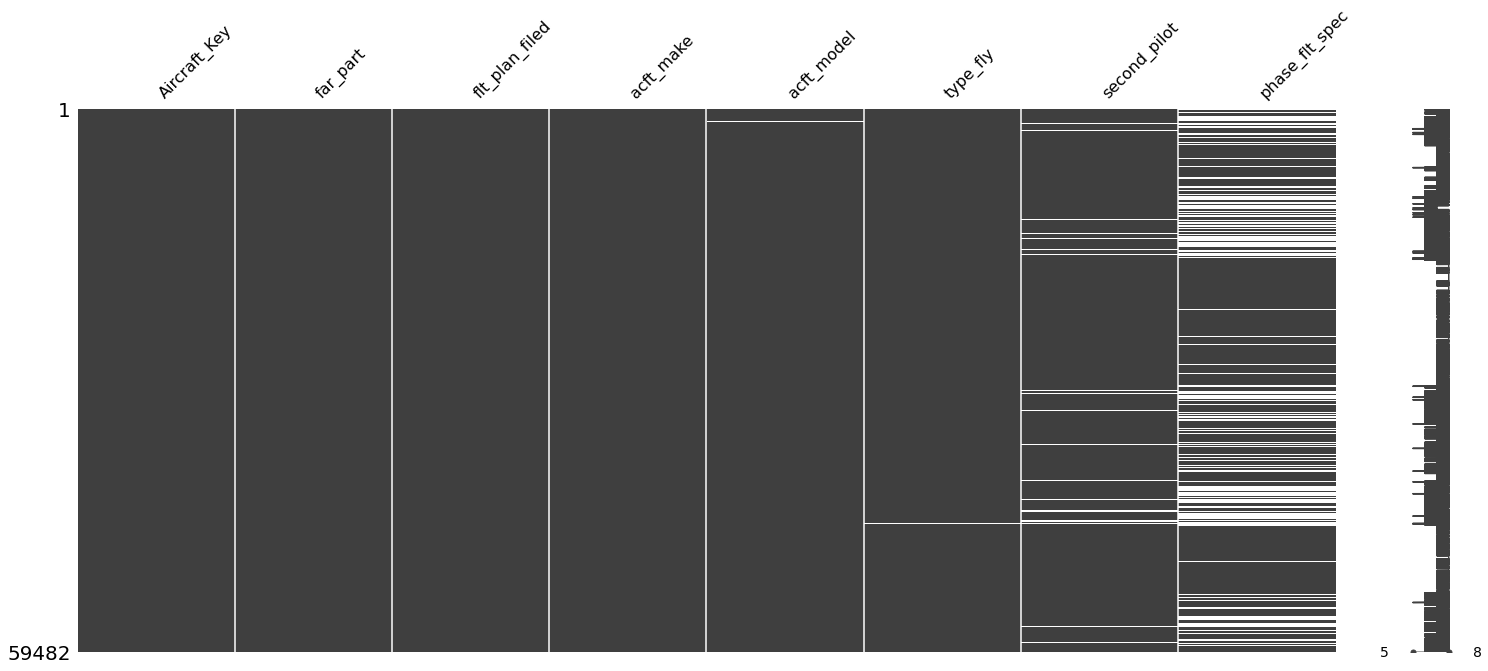

In [14]:
msno.matrix(aircraft_ga_single)
plt.show()

##### aircraft dataset current state:
- 'Second_pilot' is missing about 4% of its data. As the analysis concentrates on single pilot operations, it is important to try to derive the missing entries from other tables.

- 'phase_flt_spec' is missing 26% of values. It is yet to be determined if this column is needed for modeling. Will attempt to derive missing values.





### Import additional datasets

The filtered aircraft_ga_single dataframe index will serve as the anchor to merge the additional datasets. In this way only applicable records - General Aviation and Single (or unknown) pilot(s) -  will be merged.

### Crew Dataset

In [15]:
file = 'D:/cap/capstone2/data/raw/crew.csv'
crew = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False) 

In [16]:
crew.head(3)

,Aircraft_Key,crew_no,crew_category,crew_age,crew_sex,crew_city,crew_res_state,crew_res_country,med_certf,med_crtf_vldty,date_lst_med,crew_inj_level,seat_occ_pic,pc_profession,bfr,bfr_date
ev_id,,,,,,,,,,,,,,,,
20001204X00000,1,1,PLT,42.0,M,BETHEL,AK,NaN,CL2,VWW,3/30/1998 0:00:00,NaN,LEFT,PCIV,Y,NaN
20001204X00001,1,1,PLT,53.0,M,SCOTTSDALE,AZ,NaN,CL1,VWW,1/4/1999 0:00:00,NaN,LEFT,PCIV,Y,NaN
20001204X00002,1,1,PLT,39.0,M,ANCHORAGE,AK,NaN,CL1,VNOW,12/1/1998 0:00:00,NaN,LEFT,PCIV,Y,NaN


In [17]:
to_drop = ['crew_city', 'crew_res_state', 'crew_res_country', 'crew_inj_level', 'seat_occ_pic']
crew.drop(columns = to_drop, inplace=True)


###### Task: Analyse 'Crew Category" column and filter out unwanted records

In [18]:
info(crew, 'crew_category')

UNIQUE VALUES & COUNTS IN crew_category
['PLT  ' 'CPLT ' 'FENG ' nan 'OTHR ' 'KPLT ' 'FLTI ' 'DSTU ' 'PRPS '
 'PASS ' 'CABN ']
PLT      79257
DSTU      2873
FLTI      2383
CPLT      1795
PASS      1075
OTHR       309
PRPS       279
KPLT       145
FENG        70
CABN        40
Name: crew_category, dtype: int64
df shape: 
(88801, 11)


In [19]:
#filter out unwanted pilot categories - retain pilot, student, and empty
crew = crew[~crew['crew_category'].isin(['FLTI ', 'PASS ', 'OTHR ', 'KPLT ', 'PRPS ', 'CPLT ', 'CABN ', 'FENG '])]
info(crew, 'crew_category')

UNIQUE VALUES & COUNTS IN crew_category
['PLT  ' nan 'DSTU ']
PLT      79257
DSTU      2873
Name: crew_category, dtype: int64
df shape: 
(82705, 11)


In [20]:
#standardize unkn entry, replace codes with pilot, student for readeability
crew['crew_category'].fillna('unkn', inplace=True)
crew['crew_category'] = crew['crew_category'].str.strip()
crew['crew_category'] = crew['crew_category'].replace(['PLT', 'DSTU'], ['pilot','student'])
info(crew, 'crew_category')

UNIQUE VALUES & COUNTS IN crew_category
['pilot' 'unkn' 'student']
pilot      79257
student     2873
unkn         575
Name: crew_category, dtype: int64
df shape: 
(82705, 11)


###### Task: eliminate records containing more than one pilot based on crew_number column

In [21]:
info(crew, 'crew_no')

UNIQUE VALUES & COUNTS IN crew_no
[1 2 3 4 5 6]
1    80063
2     2544
3       81
4       12
5        4
6        1
Name: crew_no, dtype: int64
df shape: 
(82705, 11)


In [22]:
#substract multi-crew records from df
multi_crew = crew[crew['crew_no'] > 1]
crew = crew[~crew.crew_no.isin(multi_crew.crew_no)]
crew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80063 entries, 20001204X00000 to 20200724X65101
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Aircraft_Key    80063 non-null  int64  
 1   crew_no         80063 non-null  int64  
 2   crew_category   80063 non-null  object 
 3   crew_age        76169 non-null  float64
 4   crew_sex        75542 non-null  object 
 5   med_certf       78259 non-null  object 
 6   med_crtf_vldty  74900 non-null  object 
 7   date_lst_med    72485 non-null  object 
 8   pc_profession   76507 non-null  object 
 9   bfr             49800 non-null  object 
 10  bfr_date        19163 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 7.3+ MB


In [23]:
crew['crew_age'].unique()
info(crew, 'crew_age')

UNIQUE VALUES & COUNTS IN crew_age
[ 42.  53.  39.  25.  38.  43.  63.  59.  66.  33.  46.  31.  68.  50.
  54.  37.  28.  77.  55.  56.  45.  75.  23.  47.  32.  40.  44.  20.
  nan  69.  36.  35.  18.  65.  51.  60.  48.  61.  57.  41.  71.  70.
  64.  72.  29.  34.  26.  49.  58.  22.  30.  27.  73.  74.  62.  67.
  80.  81.  19.  21.  52.  24.  82.  78.  76.  79.  85.  88.  17.  91.
  15.  83.  84.  16.  86.  14.  87.  90.  89.   0.   1.  99.  92.  94.
 114.   8. 115.  98. 117.  93.]
45.0     1879
46.0     1876
51.0     1865
43.0     1856
49.0     1849
         ... 
117.0       1
114.0       1
8.0         1
94.0        1
115.0       1
Name: crew_age, Length: 89, dtype: int64
df shape: 
(80063, 11)


In [24]:
crew['crew_age'].fillna(0, inplace=True)
crew['crew_age'] = crew['crew_age'].replace('unkn', 0)

#some age values appeart to be out of range. Educated replacement is to limit max age to 100 and minimum age to 14.
#The earliest age to be a student pilot is 14 years. Minimal amount of records are affected.

#ages shown as 0 will be considered as unknown and will be derived later via total flight hour algorithm.

crew.loc[crew['crew_age'] > 100, 'crew_age'] = 100
crew.loc[(crew['crew_age'] < 14) & (crew['crew_age'] > 0) , 'crew_age'] = 14
crew['crew_age'] = crew['crew_age'].astype(int)
crew['crew_age'] = crew['crew_age'].apply(pd.to_numeric, errors='coerce')
info(crew, 'crew_age')

UNIQUE VALUES & COUNTS IN crew_age
[ 42  53  39  25  38  43  63  59  66  33  46  31  68  50  54  37  28  77
  55  56  45  75  23  47  32  40  44  20   0  69  36  35  18  65  51  60
  48  61  57  41  71  70  64  72  29  34  26  49  58  22  30  27  73  74
  62  67  80  81  19  21  52  24  82  78  76  79  85  88  17  91  15  83
  84  16  86  14  87  90  89  99  92  94 100  98  93]
0      3901
45     1879
46     1876
51     1865
43     1856
       ... 
100       3
99        2
93        1
98        1
94        1
Name: crew_age, Length: 85, dtype: int64
df shape: 
(80063, 11)


In [25]:
#crew['med_certf'] = crew['med_certf'].str.strip()
#crew['med_certf'].fillna('unkn', inplace=True)
#crew.loc[crew['med_certf'] == 'UNK'] = 'unkn'

#crew['med_certf'].unique()


In [26]:
crew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80063 entries, 20001204X00000 to 20200724X65101
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Aircraft_Key    80063 non-null  int64 
 1   crew_no         80063 non-null  int64 
 2   crew_category   80063 non-null  object
 3   crew_age        80063 non-null  int64 
 4   crew_sex        75542 non-null  object
 5   med_certf       78259 non-null  object
 6   med_crtf_vldty  74900 non-null  object
 7   date_lst_med    72485 non-null  object
 8   pc_profession   76507 non-null  object
 9   bfr             49800 non-null  object
 10  bfr_date        19163 non-null  object
dtypes: int64(3), object(8)
memory usage: 7.3+ MB


######  Medical Certificate Validity

In [27]:
crew['med_crtf_vldty'] = crew['med_crtf_vldty'].str.strip()
crew['med_crtf_vldty'].fillna('unkn', inplace=True)
crew.loc[crew['med_crtf_vldty'] == 'UNK'] = 'unkn'
print(crew['med_crtf_vldty'].value_counts())

# To ease analysis will condense categories for medical certificate validity to 'valid', 'invalid', 'unkn'.
crew['med_crtf_vldty'] = crew['med_crtf_vldty'].replace(['VWW', 'VNOW', 'WWL', 'WOWL', 'WTLS'], 'valid')
crew['med_crtf_vldty'] = crew['med_crtf_vldty'].replace(['NONE', 'EXP', 'NV', 'WOWL'], 'invalid')
crew['med_crtf_vldty'].value_counts()

VWW     26347
VNOW    24395
WWL     10770
unkn     8076
WOWL     6516
NONE     2147
EXP      1403
NV        302
WTLS      107
Name: med_crtf_vldty, dtype: int64


valid      68135
unkn        8076
invalid     3852
Name: med_crtf_vldty, dtype: int64

In [28]:
generate_profile(crew)

Initial look at missing values:
   - Crew age is missing 6% of values. Missing values could be approximated by applying median age with flight hours as the determining variable (higher flight hours usually mean a more experienced and older pilot.)
   - crew sex is missing 7% of values. Will attempt to derive missing values in proportion to resulting dataset once filtered for non-commercial operations.
   - Crew country of recidence is missing 57% of values. USA recidence can be derived from State of Recidence information. For our analysis, couuntry of recidence can be simplified to two categories (USA vs. Non-USA.)
   - Crew injury level is missing 58% of values. Will attempt to derive data from accident type i.e. incident vs accident where incidents are always non-fatal and event narratives.
   - biannual flight review (bfr) and bfr_date appear to be missing values in a complementary fashion. biannual flight review data can be derived by referencing bfr_date (if bfr_date is within valid range from completion to date of incident the bfr column should indicate 'Y')

In [29]:
file = 'D:/cap/capstone2/data/raw/crew_time.csv'
times = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False)   

In [30]:
#ac_crew_time = pd.merge(aircraft_crew, crew_time, how='left', left_on=['ev_id','Aircraft_Key_x', 'crew_no'], right_on = ['ev_id','Aircraft_Key', 'crew_no'])
#ac_crew_time.sort_values(by=['ev_id','Aircraft_Key_x', 'crew_no'], inplace=True)
#ac_crew_time.head()
#info(df, '')

In [31]:
#file = 'D:/cap/capstone2/data/raw/event.csv'
#events = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False) 
#ac_crew_event = pd.merge(ac_crew_time, events, how='left', left_on='ev_id', right_on='ev_id')
#ac_crew_event.sort_values(by=['ev_id','Aircraft_Key_x', 'crew_no'], inplace=True)
#info(ac_crew_event, '')

In [32]:
#file = 'D:/cap/capstone2/data/raw/findings.csv'
#findings = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False) 
#ac_crew_event_findings = pd.merge(ac_crew_event, findings, how='left', left_on=['ev_id','Aircraft_Key_x'], right_on = ['ev_id','Aircraft_Key'])


In [33]:
#df = ac_crew_event_findings[~ac_crew_event_findings['finding_description'].isnull()]
print(df.head(40))
#df.shape

NameError: name 'df' is not defined

In [ ]:
#initial profile
#generate_profile(df)